# Examine how fire impacts the extraction of phenology

How does it affect trends?

In [1]:
%matplotlib inline

import sys
import pickle
import warnings
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sb
import scipy.signal
from scipy import stats
import geopandas as gpd
import matplotlib.pyplot as plt
from odc.geo.xr import assign_crs
from odc.geo.geom import Geometry
from scipy.stats import circmean, circstd

sys.path.append('/g/data/os22/chad_tmp/Aus_phenology/src')
from phenology_pixel_circular import _extract_peaks_troughs, xr_phenometrics, phenology_circular_trends, mk_with_slopes, remove_circular_outliers_and_unwrap

Dask configuration key 'ucx' has been deprecated; please use 'distributed.comm.ucx' instead
Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead


## Analysis Parameters


In [2]:
ds_path = '/g/data/os22/chad_tmp/AusENDVI/results/publication/AusENDVI-clim_MCD43A4_gapfilled_1982_2022_0.2.0.nc'
# ecoregions_file = '/g/data/os22/chad_tmp/Aus_phenology/data/vectors/namadgi_region.geojson'
ecoregions_file = '/g/data/os22/chad_tmp/Aus_phenology/data/vectors/IBRAv7_subregions_modified.geojson'

## Open data

In [3]:
ds = assign_crs(xr.open_dataset(ds_path), crs='EPSG:4326')
ds = ds.rename({'AusENDVI_clim_MCD43A4':'NDVI'})
ds = ds['NDVI']

#bare soil NDVI data
ss_path = f'/g/data/xc0/project/AusEFlux/data/ndvi_of_baresoil_5km.nc'
ss = assign_crs(xr.open_dataset(ss_path)['NDVI'], crs='epsg:4326')
ss.name = 'NDVI'

## Clip to a region

In [4]:
gdf = gpd.read_file(ecoregions_file)

# k='Snowy Mountains' 'Victorian Alps' 'Highlands-Southern Fall'
k='Victorian Alps'
gdf = gdf[gdf['SUB_NAME_7'] == k]

# gdf = gdf[gdf['LOC_NAME']=='Tennent']

# gdf.explore()

In [5]:
# gdf.explore(column='SUB_NAME_7',
#             tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
#             attr = 'Esri',
#             name = 'Esri Satellite',
#             control = True,
#             legend=False
#            )

In [6]:
#clip to ecoregion
geom = Geometry(geom=gdf.iloc[0].geometry, crs=gdf.crs)
ds = ds.odc.mask(poly=geom)
ds = ds.dropna(dim='longitude', how='all').dropna(dim='latitude', how='all')

# #summarise into 1d timeseries
ds = ds.mean(['latitude', 'longitude'])

## Smoothing filters

In [7]:
#resample before we smooth
ds= ds.resample(time="2W").interpolate("linear")

# # Savitsky-Golay smoothing
ds = xr.apply_ufunc(
        scipy.signal.savgol_filter,
        ds,
        input_core_dims=[['time']],
        output_core_dims=[['time']],
        kwargs=dict(
            window_length=11,
            polyorder=3,
            deriv=0,
            mode='interp'),
        dask='parallelized'
    )

ds=ds.dropna(dim='time', how='all').resample(time='1D').interpolate(kind='quadratic')

## Extract phenometrics 

<!-- import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def double_logistic_function(t, wNDVI, mNDVI, S, A, mS, mA):
    sigmoid1 = 1 / (1 + np.exp(-mS * (t - S)))
    sigmoid2 = 1 / (1 + np.exp(mA * (t - A)))
    seasonal_term = sigmoid1 + sigmoid2 - 1
    return wNDVI + (mNDVI - wNDVI) * seasonal_term

def weight_function(t, S, A, r):
    tr = 100 * (t - S) / (A - S)
    tr = np.clip(tr, 0, 100)
    return np.exp(-np.abs(r) / (1 + tr / 10))

def fit_curve(t, ndvi_observed):
    initial_guess = [np.min(ndvi_observed), np.max(ndvi_observed), np.mean(t), np.mean(t), 1, 1]
    params, _ = curve_fit(double_logistic_function, t, ndvi_observed, p0=initial_guess, maxfev=10000)
    residuals = ndvi_observed - double_logistic_function(t, *params)
    weights = weight_function(t, params[2], params[3], residuals)
    params, _ = curve_fit(double_logistic_function, t, ndvi_observed, p0=initial_guess, sigma=weights, maxfev=10000)
    return params

doys = ndvi_cycle.time.dt.dayofyear.values[2:]
doys_frac = doys/365
values = ndvi_cycle.values[2:]

##Fit the curve
parameters = fit_curve(doys_frac, values)

##Plot the observed NDVI values
plt.scatter(doys, values, label='Observed NDVI')

##Generate points for the fitted curve
t_fit = np.linspace(min(doys_frac), max(doys_frac), 365)
ndvi_fit = double_logistic_function(t_fit, *parameters)

##Plot the fitted curve
plt.plot(t_fit*365, ndvi_fit, label='Fitted Curve', color='red')

plt.xlabel('Day of the Year')
plt.ylabel('NDVI')
plt.legend()
plt.title('Double Logistic Curve Fitting for NDVI Observations')
plt.show() -->


<!-- def xr_count_peaks(ds, order=16):
    def _find_peaks(ds):
        peaks = scipy.signal.argrelextrema(ds, np.greater, order=order)
        # peaks = scipy.signal.find_peaks(ds, height=0.2, distance=order)
        return len(peaks[0])
    
    ds_n_peaks = xr.apply_ufunc(_find_peaks,
                              ds, 
                              input_core_dims=[['time']],
                              vectorize=True, 
                              dask='parallelized',
                              output_dtypes=[np.float32]
                             )

    return ds_n_peaks.rename('n_peaks')

%%time
n_peaks = xr_count_peaks(ds_smooth.sel(time=slice('2004-09', '2006-03'))) -->

In [8]:
#bare soil NDVI clip to region
soil = ss.odc.mask(poly=geom)
soil = soil.mean().values.item()

# fake expand dims
ds = ds.expand_dims(latitude=[-33.0],longitude=[135.0])

#apply pheno
p = xr_phenometrics(ds,
                rolling=90,
                distance=90,
                prominence='auto',
                plateau_size=10,
                amplitude=0.2,
                verbose=True,
                soil_signal=soil,
                   ).compute()

## Extract trends etc.

In [9]:
trend_vars = ['POS','vPOS','TOS','vTOS','AOS','SOS','vSOS','EOS',
             'vEOS','LOS','LOC', 'IOS','IOC','ROG','ROS']

trends = phenology_circular_trends(p, vars = trend_vars).compute()

p_df = p.squeeze().drop_vars(['latitude','longitude'])

p_value, slope, intercept = mk_with_slopes(p['vPOS'].squeeze().drop_vars(['latitude','longitude']))
y_vPOS=slope*p.index+intercept

In [10]:
var='POS'
data = pd.DataFrame({
    "year": p_df[f'{var}_year'].values,
    "day_of_year": p_df[var].values
})

# Number of days in a year (adjusting for leap years)
data['days_in_year'] = data['year'].apply(lambda y: 366 if y % 4 == 0 and (y % 100 != 0 or y % 400 == 0) else 365)

# Convert day-of-year to circular coordinates doy / 365 * 2 * np.pi
data['theta'] = data['day_of_year']*((2*np.pi)/data['days_in_year'])

# Remove outliers where 3 std devs. 
data['theta_unwrap'] = remove_circular_outliers_and_unwrap(data['theta'], n_sigma=3)

# Calculate circular mean
circular_mean = circmean(data['theta'], nan_policy='omit')
circular_std = circstd(data['theta'], nan_policy='omit')

circular_mean_doy = circular_mean / (2 * np.pi) * 365
circular_std_doy = circular_std / (2 * np.pi) * 365

data['theta_unwrap_DOY_anomaly'] = data['theta_unwrap'] * 365 / (2 * np.pi) - circular_mean_doy

p_value, slope, intercept = mk_with_slopes(data['theta_unwrap_DOY_anomaly'])
y = slope*data.index+intercept

## Plot

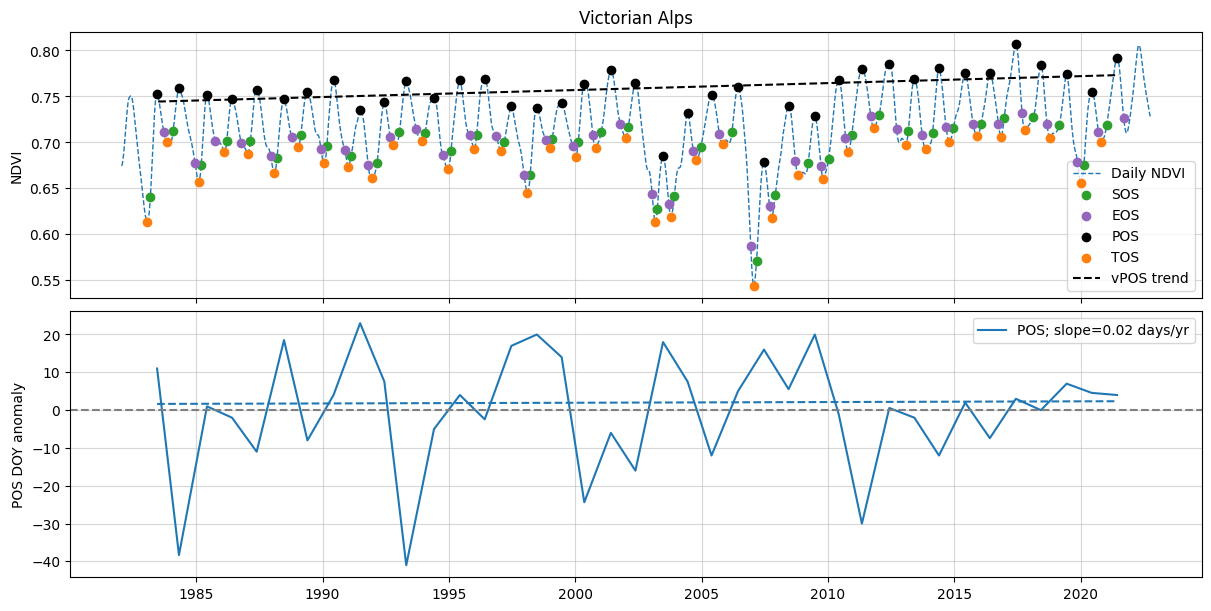

In [11]:
fig,ax=plt.subplots(2,1, figsize=(12,6), sharex=True, layout='constrained')

ds.plot(ax=ax[0], color='tab:blue', linestyle='--', linewidth=1.0, label='Daily NDVI')

# ax.set_ylim(0.15, 0.7)
ax[0].scatter(x=[pd.to_datetime(d-1, unit='D', origin=str(int(y))) for d,y in zip(p_df.SOS.values, p_df.SOS_year.values)],
       y=p.vSOS, c='tab:green', label='SOS', zorder=10)

ax[0].scatter(x=[pd.to_datetime(d-1, unit='D', origin=str(int(y))) for d,y in zip(p_df.EOS.values, p_df.EOS_year.values)],
       y=p.vEOS, c='tab:purple', label='EOS', zorder=10)

ax[0].scatter(x=[pd.to_datetime(d-1, unit='D', origin=str(int(y))) for d,y in zip(p_df.POS.values,p_df.POS_year.values)],
           y=p.vPOS, c='black', label='POS', zorder=10)

ax[0].scatter(x=[pd.to_datetime(d-1, unit='D', origin=str(int(y))) for d,y in zip(p_df.TOS.values, p_df.TOS_year.values)],
       y=p.vTOS, c='tab:orange', label='TOS', zorder=10)

ax[0].plot([pd.to_datetime(182, unit='D', origin=str(int(y))) for y in p.POS_year.data[0][0]],
           y_vPOS, color='black', linestyle='--', label='vPOS trend')

ax[0].legend()
ax[0].set_xlabel(None)
ax[0].set_ylabel('NDVI')
ax[0].set_title(k, fontsize=12)
ax[0].grid(which='both', alpha=0.5);

# x = list(range(1983,2022))
x=[pd.to_datetime(d-1, unit='D', origin=str(int(y))) for d,y in zip(data['day_of_year'].values,data['year'].values)]

ax[1].plot(x, data['theta_unwrap_DOY_anomaly'], label=f'{var}; slope={slope:.2f} days/yr', color='tab:blue')
ax[1].plot(x, y, color='tab:blue', linestyle='--')
ax[1].axhline(0, color='grey', linestyle='--')
ax[1].legend()
ax[1].set_xlabel(None)
ax[1].set_ylabel(f'{var} DOY anomaly')
ax[1].set_title(None)
ax[1].grid(which='both', alpha=0.5);